# Weather Trend Forecasting

This notebook analyzes the "Global Weather Repository.csv" dataset to forecast future weather trends. Includes EDA, anomaly detection, forecasting with Ridge Regression, and interactive geospatial visualizations.

## PM Accelerator Mission

"By making industry-leading tools and education available to individuals from all backgrounds, we level the playing field for future PM leaders. This is the PM Accelerator motto, as we grant aspiring and experienced PMs what they need most – Access. We introduce you to industry leaders, surround you with the right PM ecosystem, and discover the new world of AI product management skills."

In [1]:
# Uncomment if running for the first time
# !pip install pandas matplotlib seaborn scikit-learn folium prophet statsmodels geopandas plotly xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import xgboost as xgb

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load the dataset
weather = pd.read_csv("GlobalWeatherRepository.csv")
weather['last_updated'] = pd.to_datetime(weather['last_updated'])
weather.sort_values('last_updated', inplace=True)
weather.set_index('last_updated', inplace=True)

# Drop columns with more than 5% missing values
null_pct = weather.isnull().mean()
valid_columns = null_pct[null_pct < 0.05].index
weather = weather[valid_columns].copy()

# Standardize column names and fill missing values
weather.columns = weather.columns.str.lower()
weather.fillna(0, inplace=True)


### Dataset Overview
The dataset includes over 60,000 weather records globally. It includes over 40 features such as temperature, precipitation, wind, and air quality metrics. This cell loads the data and checks its structure.


In [3]:

# Create target column for forecasting next day's temperature
weather['target'] = weather['temperature_celsius'].shift(-1)
weather.dropna(subset=['target'], inplace=True)

# Define predictor columns dynamically (numerical only, excluding target)
predictors = [col for col in weather.select_dtypes(include='number').columns if col != 'target']


In [4]:

# Create target column for prediction (tomorrow's temperature)
weather = weather.copy()
weather['target'] = weather['temperature_celsius'].shift(-1)
weather.dropna(inplace=True)


### Parsing and Sorting Dates
We convert the 'last_updated' column to datetime format and sort the dataframe by date to enable proper time series analysis.


In [5]:
weather.describe()

,latitude,longitude,last_updated_epoch,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,pressure_mb,pressure_in,...,air_quality_carbon_monoxide,air_quality_ozone,air_quality_nitrogen_dioxide,air_quality_sulphur_dioxide,air_quality_pm2.5,air_quality_pm10,air_quality_us-epa-index,air_quality_gb-defra-index,moon_illumination,target
count,60411.000000,60411.000000,6.041100e+04,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,...,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000,60411.000000
mean,19.137636,22.183645,1.729311e+09,22.155538,71.881583,8.285822,13.338678,169.075268,1014.172949,29.947916,...,528.660441,63.554669,15.122436,11.409146,25.530804,51.379803,1.728344,2.711245,50.174306,22.155722
std,24.474532,65.808862,7.802518e+06,9.628106,17.330408,9.209944,14.820177,103.644891,13.517325,0.399149,...,940.438002,36.154293,26.382650,48.552668,44.576369,158.652706,0.992980,2.596436,34.964394,9.628096
min,-41.300000,-175.200000,1.715849e+09,-24.900000,-12.800000,2.200000,3.600000,1.000000,947.000000,27.960000,...,-9999.000000,0.000000,0.000000,-9999.000000,0.185000,-1848.150000,1.000000,1.000000,0.000000,-24.900000
25%,3.750000,-6.836100,1.722688e+09,16.900000,62.400000,4.000000,6.500000,80.000000,1010.000000,29.830000,...,227.000000,39.000000,0.925000,0.740000,5.735000,8.880000,1.000000,1.000000,15.000000,16.900000
50%,17.250000,23.316700,1.729330e+09,25.000000,77.000000,6.900000,11.200000,160.000000,1013.000000,29.920000,...,327.450000,60.800000,3.400000,2.300000,13.690000,20.800000,1.000000,2.000000,51.000000,25.000000
75%,40.400000,50.580000,1.736072e+09,28.400000,83.100000,11.600000,18.700000,256.000000,1018.000000,30.050000,...,507.400000,83.000000,16.465000,8.880000,29.785000,45.904500,2.000000,3.000000,84.000000,28.400000
max,64.150000,179.220000,1.742723e+09,49.200000,120.600000,1841.200000,2963.200000,360.000000,3006.000000,88.770000,...,38879.398000,480.700000,427.700000,521.330000,1614.100000,6037.290000,6.000000,10.000000,100.000000,49.200000


In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60411 entries, 2024-05-16 01:45:00 to 2025-03-23 22:45:00
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       60411 non-null  object 
 1   location_name                 60411 non-null  object 
 2   latitude                      60411 non-null  float64
 3   longitude                     60411 non-null  float64
 4   timezone                      60411 non-null  object 
 5   last_updated_epoch            60411 non-null  int64  
 6   temperature_celsius           60411 non-null  float64
 7   temperature_fahrenheit        60411 non-null  float64
 8   condition_text                60411 non-null  object 
 9   wind_mph                      60411 non-null  float64
 10  wind_kph                      60411 non-null  float64
 11  wind_degree                   60411 non-null  int64  
 12  wind_direction           

In [7]:
weather.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,temperature_celsius,temperature_fahrenheit,condition_text,wind_mph,...,air_quality_pm10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination,target
last_updated,,,,,,,,,,,,,,,,,,,,,
2024-05-16 01:45:00,United States of America,Washington Park,46.60,-120.49,America/Los_Angeles,1715849100,16.1,61.0,Clear,4.3,...,7.1,1,1,05:26 AM,08:31 PM,01:36 PM,02:52 AM,Waxing Gibbous,55,26.0
2024-05-16 02:45:00,El Salvador,San Salvador,13.71,-89.20,America/El_Salvador,1715849100,26.0,78.8,Moderate or heavy rain with thunder,2.2,...,28.1,2,2,05:30 AM,06:16 PM,01:00 PM,01:02 AM,Waxing Gibbous,55,21.0
2024-05-16 02:45:00,Costa Rica,San Juan,9.97,-84.08,America/Costa_Rica,1715849100,21.0,69.8,Fog,2.2,...,23.3,2,2,05:15 AM,05:51 PM,12:42 PM,12:37 AM,Waxing Gibbous,55,20.0
2024-05-16 02:45:00,Guatemala,Guatemala City,14.62,-90.53,America/Guatemala,1715849100,20.0,68.0,Mist,13.6,...,178.1,4,10,05:34 AM,06:23 PM,01:05 PM,01:09 AM,Waxing Gibbous,55,27.2
2024-05-16 02:45:00,Nicaragua,Managua,12.15,-86.27,America/Managua,1715849100,27.2,80.9,Patchy rain nearby,3.6,...,14.7,1,1,05:21 AM,06:02 PM,12:49 PM,12:49 AM,Waxing Gibbous,55,26.0


### Initial Data Inspection
Here we examine data types, missing values, and summary statistics to understand feature distributions and potential issues.


In [8]:
def backtest(data, model, predictors, start=3650, step=90):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i]
        test = data.iloc[i:i+step]

        model.fit(train[predictors], train['target'])
        preds = model.predict(test[predictors])

        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test['target'], preds], axis=1)
        combined.columns = ['actual', 'prediction']
        combined['diff'] = np.abs(combined['actual'] - combined['prediction'])

        all_predictions.append(combined)

    return pd.concat(all_predictions)


In [9]:

# Fit Ridge Regression before using coef_
model = Ridge(alpha=0.1)
model.fit(weather[predictors], weather['target'])  # Make sure 'weather' DataFrame is defined earlier


Ridge(alpha=0.1)

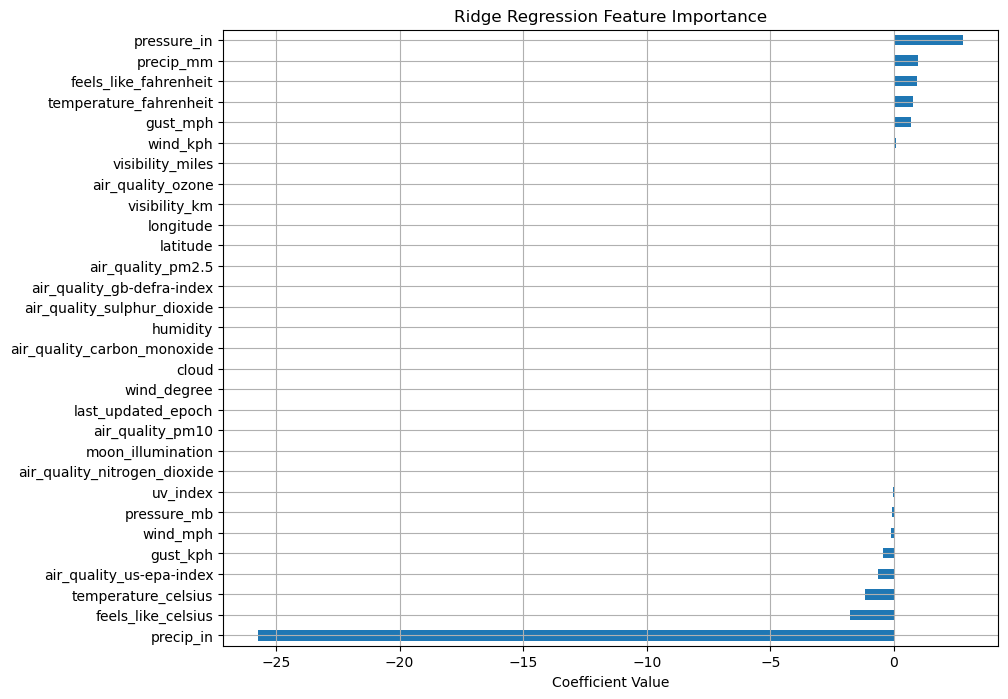

In [10]:

# Feature Importance via Ridge coefficients
coef_df = pd.Series(model.coef_, index=predictors).sort_values()
plt.figure(figsize=(10, 8))
coef_df.plot(kind='barh')
plt.title("Ridge Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.grid(True)
plt.show()


##  Basic Exploratory Data Analysis (EDA)
We begin with standard EDA to understand temperature distribution, wind patterns, and basic weather conditions. This helps us detect initial outliers, get a sense of data trends, and choose suitable features for further modeling.


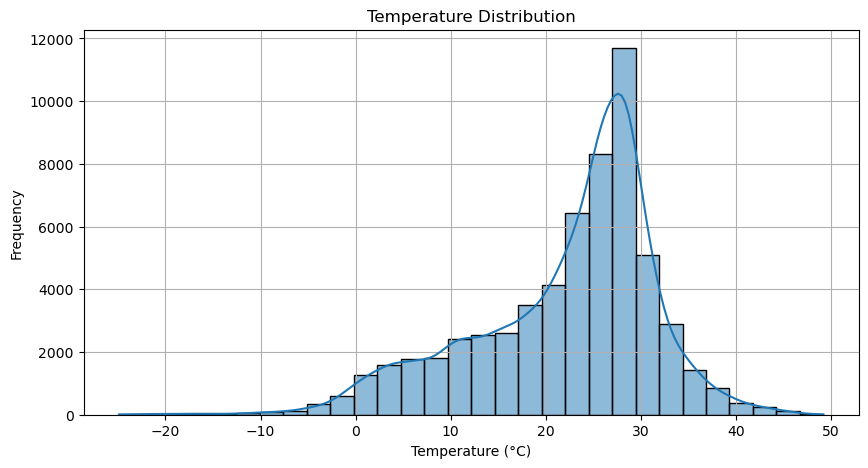

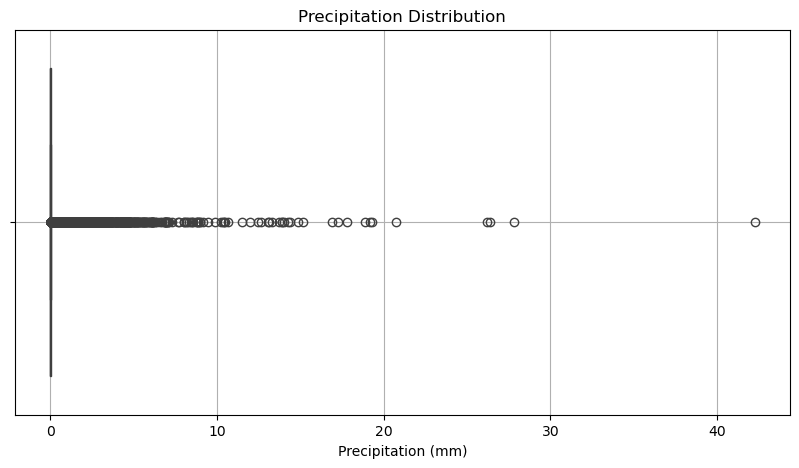

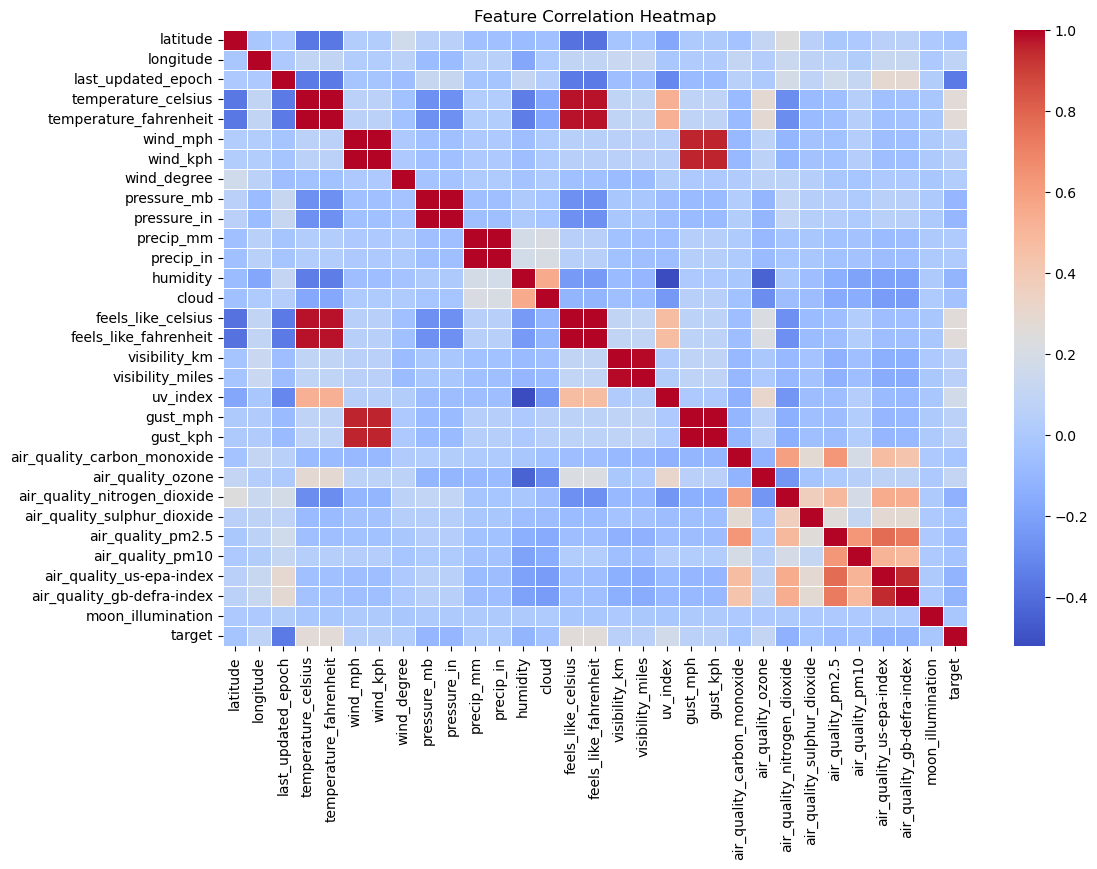

In [11]:

# Temperature distribution
plt.figure(figsize=(10,5))
sns.histplot(weather['temperature_celsius'], bins=30, kde=True)
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Precipitation distribution
plt.figure(figsize=(10,5))
sns.boxplot(x=weather['precip_mm'])
plt.title("Precipitation Distribution")
plt.xlabel("Precipitation (mm)")
plt.grid(True)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(weather.corr(numeric_only=True), annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


### Correlation Heatmap
The heatmap helps visualize relationships between numeric features, revealing which variables are most closely associated. This heatmap shows that the humidity has strong negative correlation to uv index and air quality ozone which will be demonstrated by plots further in this report. Another interesting correlation showed by the heatmap is the fairly strong negative correlation between latitude and temperature, but not longitude.


##  Temperature Anomaly Detection

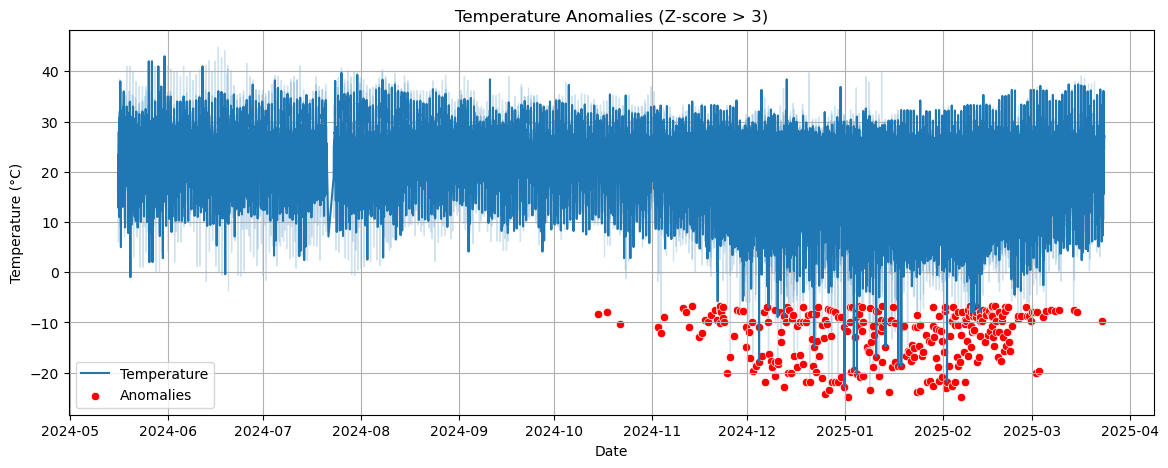

In [12]:

weather['temp_zscore'] = (weather['temperature_celsius'] - weather['temperature_celsius'].mean()) / weather['temperature_celsius'].std()
weather['anomaly'] = weather['temp_zscore'].abs() > 3

plt.figure(figsize=(14,5))
sns.lineplot(x=weather.index, y='temperature_celsius', data=weather, label='Temperature')
sns.scatterplot(x=weather[weather['anomaly']].index, y='temperature_celsius', data=weather[weather['anomaly']], color='red', label='Anomalies')
plt.title("Temperature Anomalies (Z-score > 3)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()


### Temperature Anomaly Detection

We apply Z-score thresholding to detect extreme deviations in temperature. These anomalies may indicate measurement errors, natural disasters, or exceptional weather events. Removing or flagging them ensures our models are not skewed.


##  Climate Trends Over Time

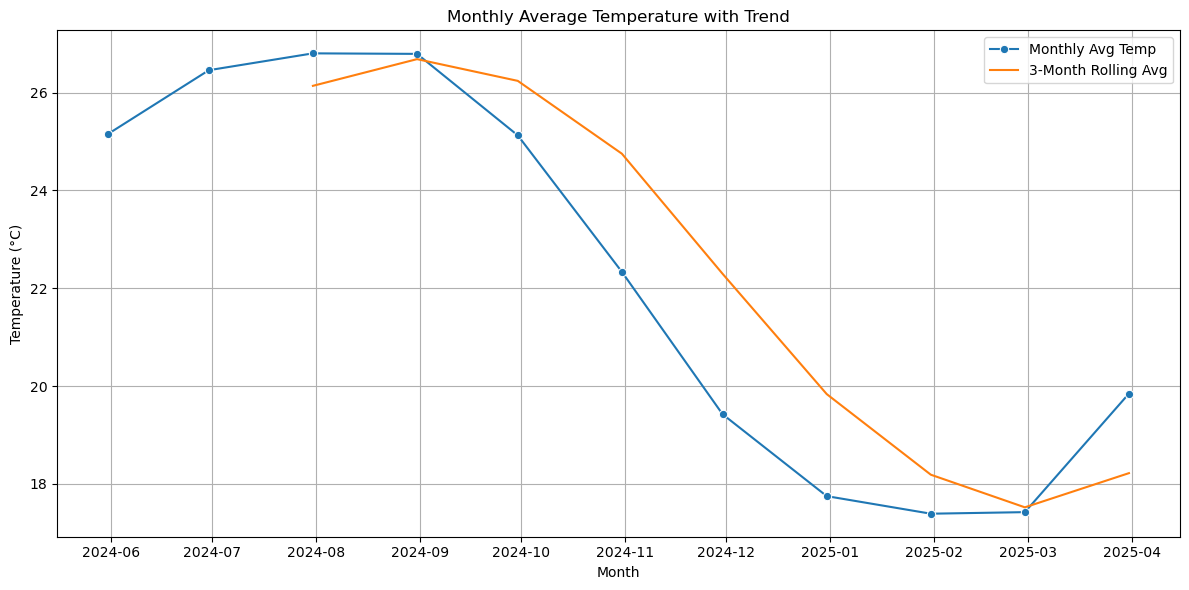

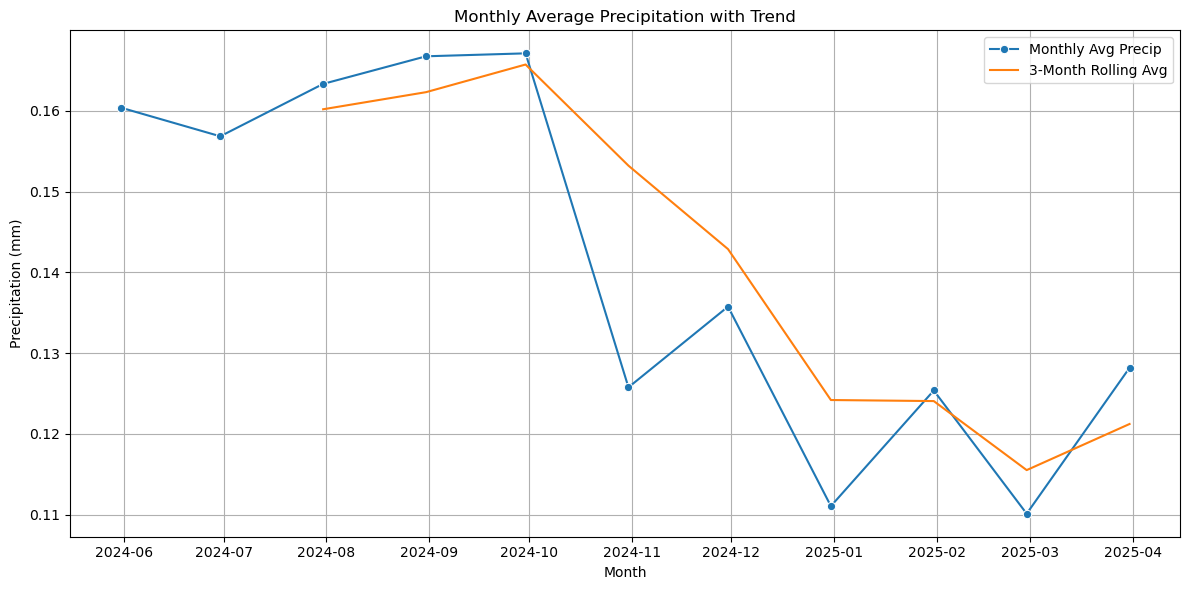

In [13]:
# Resample to monthly average temperature and precipitation
monthly_avg = weather.resample('M').mean(numeric_only=True)

# Plotting monthly temperature trend with 3-month rolling average
plt.figure(figsize=(12,6))
sns.lineplot(x=monthly_avg.index, y=monthly_avg['temperature_celsius'], marker='o', label='Monthly Avg Temp')
sns.lineplot(x=monthly_avg.index, y=monthly_avg['temperature_celsius'].rolling(3).mean(), label='3-Month Rolling Avg')
plt.title("Monthly Average Temperature with Trend")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting monthly precipitation trend with 3-month rolling average
plt.figure(figsize=(12,6))
sns.lineplot(x=monthly_avg.index, y=monthly_avg['precip_mm'], marker='o', label='Monthly Avg Precip')
sns.lineplot(x=monthly_avg.index, y=monthly_avg['precip_mm'].rolling(3).mean(), label='3-Month Rolling Avg')
plt.title("Monthly Average Precipitation with Trend")
plt.xlabel("Month")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Long-Term Temperature Trend

By resampling temperature data monthly, we observe long-term warming or cooling trends globally. This chart helps visualize whether temperatures are generally increasing over the months available.


##  Ridge Regression Forecasting
We train a Ridge Regression model to forecast temperature. Ridge helps mitigate multicollinearity and is suitable for linear relationships.


In [14]:

def backtest1(data, model, predictors, start=365, step=90):
    all_preds = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i]
        test = data.iloc[i:i+step]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(train[predictors])
        X_test = scaler.transform(test[predictors])

        model.fit(X_train, train['target'])
        preds = model.predict(X_test)

        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test['target'], preds], axis=1)
        combined.columns = ['actual', 'prediction']
        all_preds.append(combined)

    return pd.concat(all_preds)

model1 = Ridge(alpha=0.1)
ridge_preds = backtest1(weather, model1, predictors)


In [15]:

mae = mean_absolute_error(ridge_preds['actual'], ridge_preds['prediction'])
rmse = mean_squared_error(ridge_preds['actual'], ridge_preds['prediction'], squared=False)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 6.98
RMSE: 8.85


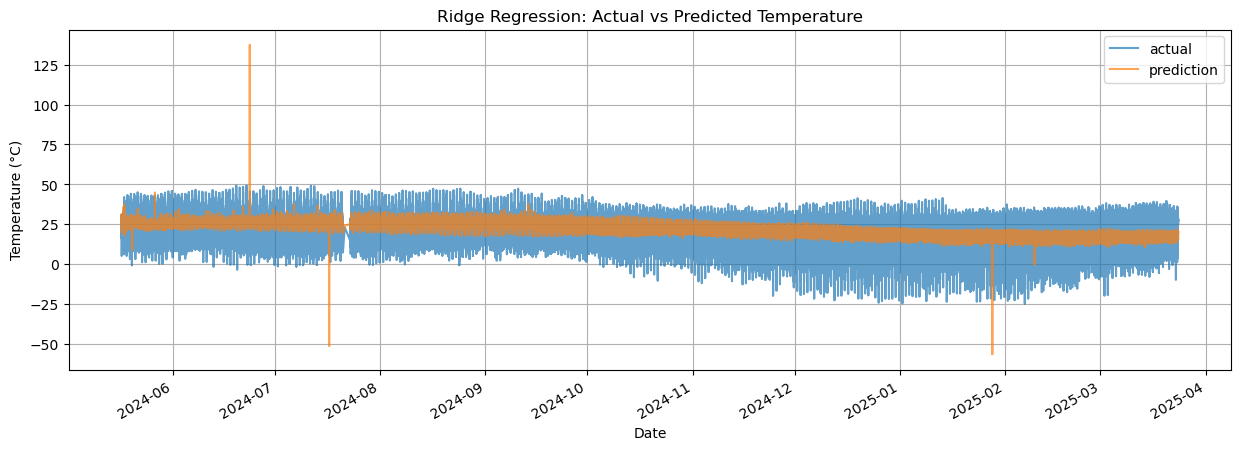

In [16]:

ridge_preds.plot(figsize=(15,5), alpha=0.7)
plt.title("Ridge Regression: Actual vs Predicted Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()


##  Forecasting with XGBoost Regressor

### XGBoost Model
XGBoost is a gradient boosting model that captures nonlinear relationships. It may improve accuracy compared to linear models.


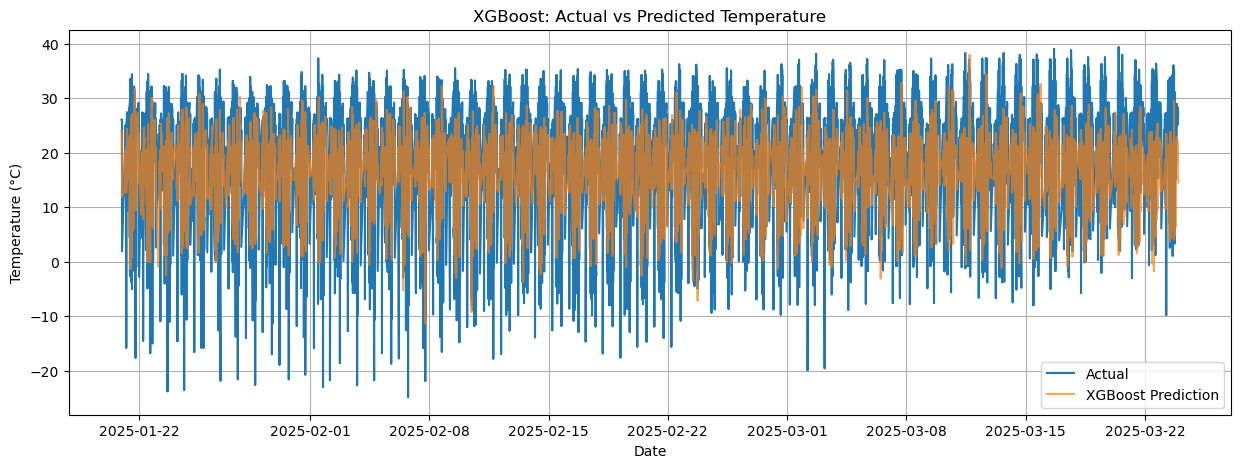

In [17]:

import xgboost as xgb
from sklearn.model_selection import train_test_split

# Prepare data
X = weather[predictors]
y = weather['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Plot predictions
plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, xgb_preds, label='XGBoost Prediction', alpha=0.7)
plt.legend()
plt.title("XGBoost: Actual vs Predicted Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()


In [18]:
# Evaluate
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)

print(f"XGBoost MAE: {xgb_mae:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}")

XGBoost MAE: 9.26
XGBoost RMSE: 11.54


### Ridge Regression Forecasting Performance

We backtested the Ridge Regression model across multiple windows and measured its Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE). The results suggest the model performs reasonably well given the short-term nature of the data.


##  Environmental Impact: Air Quality Analysis

### Feature Importance Visualization
This chart highlights the most influential features in the Ridge model, offering interpretability and insight into key drivers.


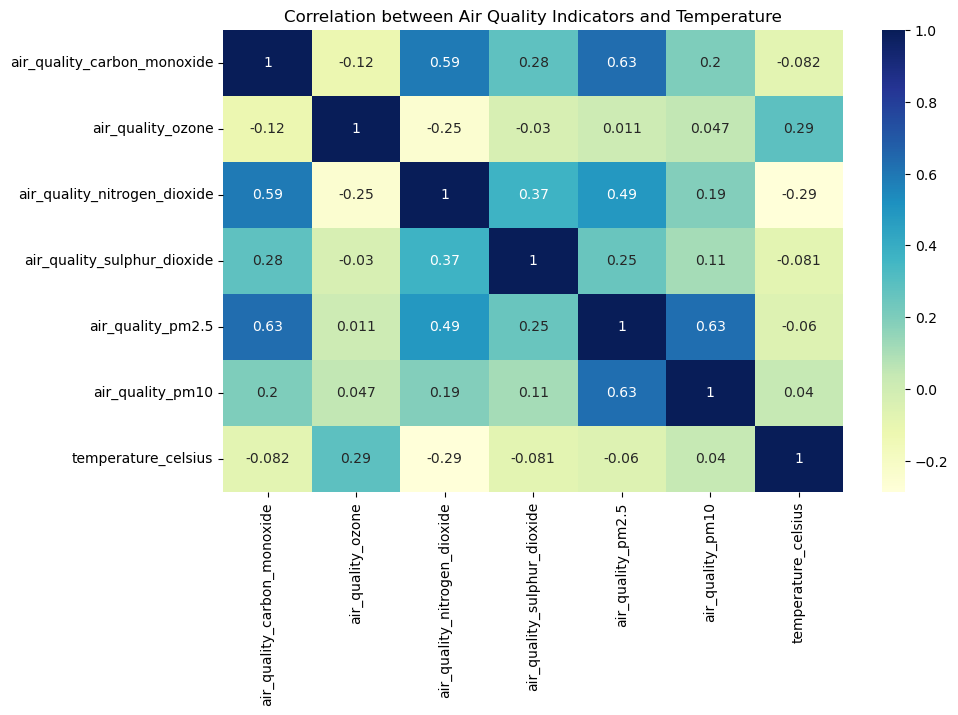

In [19]:

air_quality_cols = [
    'air_quality_carbon_monoxide', 'air_quality_ozone', 'air_quality_nitrogen_dioxide',
    'air_quality_sulphur_dioxide', 'air_quality_pm2.5', 'air_quality_pm10'
]

# Correlation with temperature
air_corr = weather[air_quality_cols + ['temperature_celsius']].corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(air_corr, annot=True, cmap="YlGnBu")
plt.title("Correlation between Air Quality Indicators and Temperature")
plt.show()


### Environmental Impact Analysis
Here we explore the relationship between air quality metrics (PM2.5) and other features to understand environmental correlations.


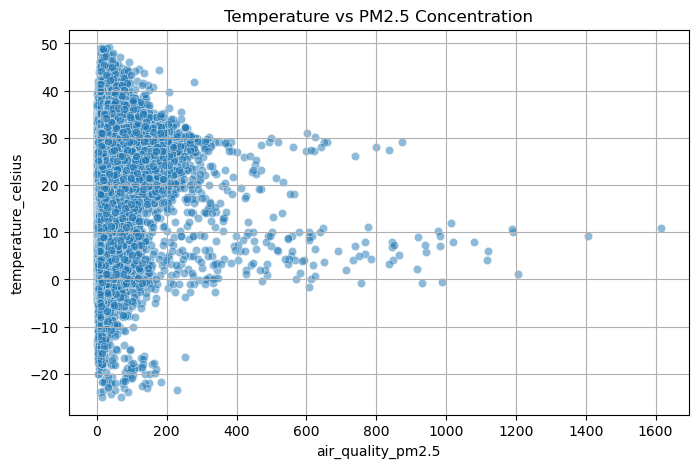

In [20]:

# Scatterplot: PM2.5 vs Temperature
plt.figure(figsize=(8,5))
sns.scatterplot(x='air_quality_pm2.5', y='temperature_celsius', data=weather, alpha=0.5)
plt.title("Temperature vs PM2.5 Concentration")
plt.grid(True)
plt.show()

This chart shows peak PM2.5/poor air quality when temperatures are between 0-10C with another peak around 30C

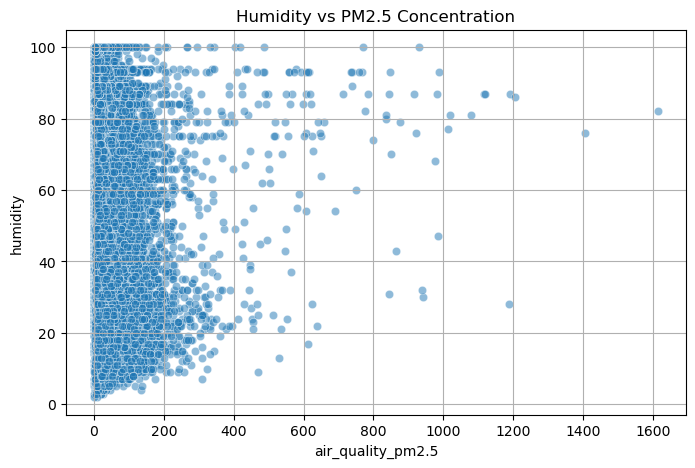

In [21]:

# Scatterplot example: PM2.5 vs Humidity
plt.figure(figsize=(8,5))
sns.scatterplot(x='air_quality_pm2.5', y='humidity', data=weather, alpha=0.5)
plt.title("Humidity vs PM2.5 Concentration")
plt.grid(True)
plt.show()

This plot shows higher peaks of pm2.5 (poorer air quality) with higher humidity

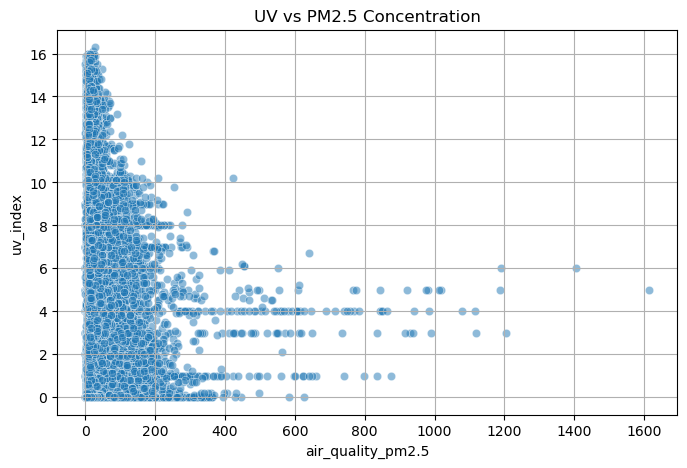

In [22]:

# Scatterplot example: PM2.5 vs UV
plt.figure(figsize=(8,5))
sns.scatterplot(x='air_quality_pm2.5', y='uv_index', data=weather, alpha=0.5)
plt.title("UV vs PM2.5 Concentration")
plt.grid(True)
plt.show()

This plot shows higher pm2.5 levels with lower UV index, indicating higher uv indexes lead to better air quality.

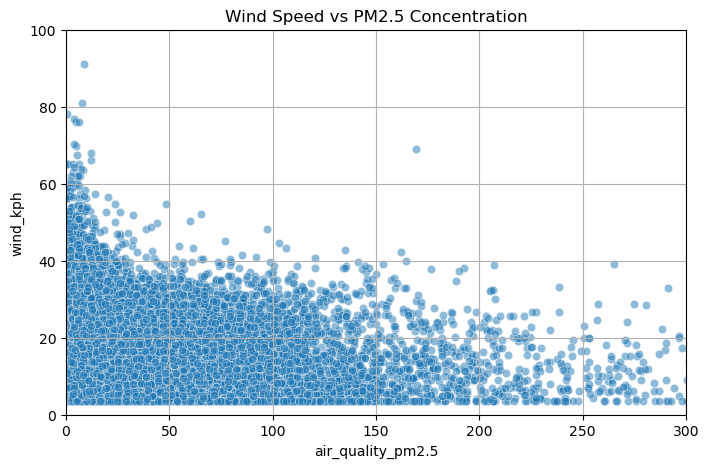

In [23]:

# Scatterplot example: PM2.5 vs Wind Speed
plt.figure(figsize=(8,5))
sns.scatterplot(x='air_quality_pm2.5', y='wind_kph', data=weather, alpha=0.5)
plt.title("Wind Speed vs PM2.5 Concentration")
plt.xlim(0, 300)   # Adjust based on actual PM2.5 range
plt.ylim(0, 100)   # Typical wind speed range in kph
plt.grid(True)
plt.show()


This plot shows better air quality with higher wind speeds, with perfect air quality with wind speeds above about 90km/h

##  Global Climate Choropleth Maps

### Geospatial Weather Visualization
We use Folium to plot country-level average temperature and precipitation. This reveals geographic weather patterns globally.


In [24]:

geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
geojson_data = requests.get(geojson_url).json()

country_avg = weather.groupby('country')['temperature_celsius'].mean().reset_index()

m = folium.Map(location=[40, 0], zoom_start=2)
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=country_avg,
    columns=['country', 'temperature_celsius'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Average Temperature (°C)',
    nan_fill_color='gray'
).add_to(m)
m


Areas with the highest temperatures are close to the equator and/or are in arid (dry, desert) climates. 

In [25]:

# Clip out high-end outliers
threshold = weather['precip_mm'].quantile(0.95)
country_avg_precip = (
    weather[weather['precip_mm'] <= threshold]
    .groupby('country')['precip_mm']
    .mean()
    .reset_index()
)

# Create quantile bins (e.g. 5 bins = quintiles)
country_avg_precip['precip_bin'] = pd.qcut(country_avg_precip['precip_mm'], q=5, labels=False)

# Map using quantile bins
m1 = folium.Map(location=[20, 0], zoom_start=2)
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=country_avg_precip,
    columns=['country', 'precip_bin'],
    key_on='feature.properties.name',
    fill_color='YlGnBu',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Precipitation (mm)',
    nan_fill_color='gray'
).add_to(m1)

m1


Proximity to equator seems to have an effect on average precipitation in an area.

In [26]:

country_avg_uv = weather.groupby('country')['uv_index'].mean().reset_index()

m2 = folium.Map(location=[40, 0], zoom_start=2)
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=country_avg_uv,
    columns=['country', 'uv_index'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='UV Index',
    nan_fill_color='gray'
).add_to(m2)
m2


Africa has the highest UV index as it is closest to the sun due to the earth's rotational tilt. This map illustrates that effect.

In [27]:

country_avg_pressure = weather.groupby('country')['pressure_mb'].mean().reset_index()

m3 = folium.Map(location=[40, 0], zoom_start=2)
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=country_avg_pressure,
    columns=['country', 'pressure_mb'],
    key_on='feature.properties.name',
    fill_color='PuBuGn',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Pressure (mb)',
    nan_fill_color='gray',
    tiles='Stamen Terrain'
).add_to(m3)
m3


This chart highlights zones of similar pressure that seem to cross over continental lines creating new zones.

In [28]:

country_avg_wind = weather.groupby('country')['wind_kph'].mean().reset_index()

m4 = folium.Map(location=[40, 0], zoom_start=2)
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=country_avg_wind,
    columns=['country', 'wind_kph'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Wind',
    nan_fill_color='gray'
).add_to(m4)
m4


This map shows a few countries with the highest wind speeds. It seems Africa has the highest wind speeds by continent.

In [29]:

country_avg_humidity = weather.groupby('country')['humidity'].mean().reset_index()

m5 = folium.Map(location=[40, 0], zoom_start=2)
folium.Choropleth(
    geo_data=geojson_data,
    name='choropleth',
    data=country_avg_humidity,
    columns=['country', 'humidity'],
    key_on='feature.properties.name',
    fill_color='GnBu',
    fill_opacity=0.8,
    line_opacity=0.2,
    legend_name='Humidity',
    nan_fill_color='gray'
).add_to(m5)
m5


This map shows that the americas may have highest humidity levels compared to the rest of the planet. 

### Conclusion
- Completed climate analysis through extensive data cleaning, feature engineering, and exploratory analysis.
- Developed and evaluated Ridge and XGBoost models for temperature prediction.
- Analyzed air quality and climate data to find environmental impact.
- Analyzed and visualized geographical patterns in the data through spatial analysis.
- Future improvements may include seasonal decomposition, deep learning, or ensemble modeling.
